# AI Community @ Семинар № 4, весна 2018
## Машинный перевод и Внимание: Практика

In [12]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import time

from matplotlib import pyplot as plt
from matplotlib import ticker
from os.path import join

use_cuda = torch.cuda.is_available()
hidden_size = 256
%matplotlib inline

In [2]:
from util import prepareData, variablesFromPair, timeSince, evaluate, showPlot, evaluateAndShowAttention
from util import SOS_token, EOS_token, MAX_LENGTH

Загрузим данные

In [3]:
input_lang_german, output_lang_german, pairs_german = prepareData('eng', 'deu', True)
input_lang_spanish, output_lang_spanish, pairs_spanish = prepareData('eng', 'spa', True)

Reading lines...
Read 159204 sentence pairs
Trimmed to 8863 sentence pairs
Counting words...
Counted words:
deu 4543
eng 3003
Reading lines...
Read 115245 sentence pairs
Trimmed to 7400 sentence pairs
Counting words...
Counted words:
spa 3908
eng 2788


## Кодировщик

![](./images/encoder.png)

In [4]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

## Декодировщик

![](./images/decoder.png)

In [5]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

## Внимательный декодировщик

![](./images/attention.png)

![](./images/attention_decoder.png)

In [6]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

## Обучение

In [7]:
teacher_forcing_ratio = 0.5

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

In [8]:
def trainIters(encoder, decoder, input_lang, output_lang, pairs, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs), input_lang, output_lang)
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
encoder1 = EncoderRNN(input_lang_german.n_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang_german.n_words, dropout_p=0.1)


if use_cuda:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

trainIters(encoder1, attn_decoder1, input_lang_german, output_lang_german, pairs_german, 20000, print_every=100)

In [9]:
def evaluateRandomly(encoder, decoder, input_lang, output_lang, pairs, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
evaluateRandomly(encoder1, attn_decoder1, input_lang_german, output_lang_german, pairs_german)

In [ ]:
w, _ = evaluate(encoder1, attn_decoder1, ' wasser ', input_lang_german, output_lang_german)
w

## Сохранение и загрузка модели

In [ ]:
torch.save(encoder1.state_dict(), "./models/encoder")
torch.save(attn_decoder1.state_dict(), "./models/decoder")

In [ ]:
encoder2 = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1)
encoder2.load_state_dict(torch.load("./models/encoder"))
attn_decoder2.load_state_dict(torch.load("./models/decoder"))

## Обученные модели

In [10]:
def load_models(encoder_name, decoder_name, input_lang, output_lang, models_path='./models/'):
    encoder = EncoderRNN(input_lang.n_words, hidden_size)
    decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1)
    encoder.load_state_dict(torch.load(join(models_path, encoder_name), map_location=lambda storage, loc: storage))
    decoder.load_state_dict(torch.load(join(models_path, decoder_name), map_location=lambda storage, loc: storage))
    return encoder, decoder

### Немецкий

![](./images/german_loss.png)

In [13]:
encoder_german, decoder_german = load_models("encoder_german", "decoder_german", input_lang_german, output_lang_german)

In [14]:
evaluateRandomly(encoder_german, decoder_german, input_lang_german, output_lang_german, pairs_german)

> sie fotografiert gerne .
= she s fond of taking pictures .
< she s fond of she . <EOS>

> sie isst fur zwei .
= she s eating for two .
< she s eating for two . <EOS>

> ich bin heute niedergeschlagen .
= i m in low spirits today .
< i m in low today spirits today . <EOS>

> ihr verschwendet blo eure zeit .
= you re just wasting your time .
< you re just wasting your time . <EOS>

> ich fahre erst morgen .
= i m not leaving until tomorrow .
< i m not leaving until tomorrow . <EOS>

> wir sind partner .
= we re partners .
< we re partners . <EOS>

> ich gehe schnell duschen .
= i m going to take a quick shower .
< i m going to take a shower . <EOS>

> es tut mir sehr leid das zu horen .
= i am really sorry to hear that .
< i am really sorry to hear that . . <EOS>

> ich mache mir gro e sorgen um tom .
= i m very worried about tom .
< i m very worried about tom . <EOS>

> das war sicher nicht mit absicht .
= i m sure that wasn t intentional .
< i m sure that t t to . <EOS>



### Испанский

![](./images/spanish_loss.png)

In [15]:
encoder_spanish, decoder_spanish = load_models("encoder_spanish", "decoder_spanish", input_lang_spanish, output_lang_spanish)

In [16]:
evaluateRandomly(encoder_spanish, decoder_spanish, input_lang_spanish, output_lang_spanish, pairs_spanish)

> no me gusta su cara .
= i m not fond of her face .
< i m not fond of her face . <EOS>

> soy bueno esquiando .
= i m good at skiing .
< i m good at skiing . <EOS>

> voy de camino a la estacion .
= i m on my way to the station .
< i m on my way to way . <EOS>

> estamos en una biblioteca .
= we are in a library .
< we re a bad library . <EOS>

> somos los padres de tom .
= we re tom s parents .
< we re tom s parents . <EOS>

> me estoy preguntando si la amo .
= i m wondering if i love her .
< i m wondering if i love her . <EOS>

> aqui todos somos canadienses .
= we re all canadians here .
< we re all canadians here . <EOS>

> yo no estoy acostumbrado a trabajar duro .
= i am not used to hard work .
< i am not accustomed to hard at work . <EOS>

> le envio una postal .
= she sent him a postcard .
< she sent him a postcard . <EOS>

> el es mas brillante que ellos .
= he s brighter than they are .
< he s brighter than they are . <EOS>



## Посмотрим на внимание

input = ich warte hier
output = i m waiting for my . <EOS>


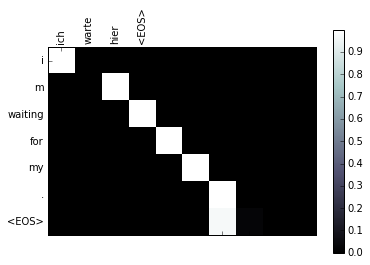

In [31]:
evaluateAndShowAttention("ich warte hier", encoder_german, decoder_german, input_lang_german, output_lang_german)

Источники:
1. [Pytorch seq2seq tutorial](http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)
2. [Про Attention](https://arxiv.org/abs/1406.6247)
3. [Еще про Attention](https://arxiv.org/abs/1508.04025)